<a href="https://colab.research.google.com/github/adiojha629/HaltConv/blob/main/Halt_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch #Pytorch used for Model creation
import torchvision
from torchvision import datasets, transforms # 'datasets' gives us MNIST, 'transforms' allows use to turn images into tensors
import matplotlib.pyplot as plt #To View Images
import torch.nn as nn #To set up the model
import torch.nn.functional as F #To calculate loss, use different activations etc.
import torch.optim as optim #To access the adam optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import torch.optim as optim
from operator import add,truediv

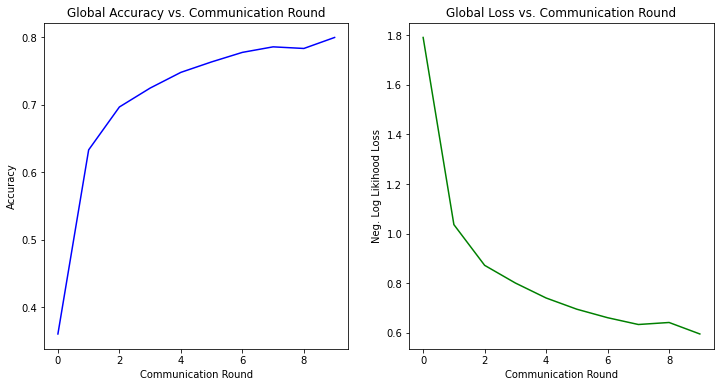

In [9]:
vanilla_fl_dict = {'Server': [[1.791189040851593, 0.3603], [1.0364729088753462, 0.6331], [0.8723062273774296, 0.6967], [0.8009874275865033, 0.7247], [0.7405818013698329, 0.748], [0.695321643771138, 0.7635], [0.6611248622483574, 0.7776], [0.6337108630706091, 0.7858], [0.6418373847729526, 0.7834], [0.5955128319623647, 0.7997]]}
test_accuracy = [vanilla_fl_dict['Server'][i][1] for i in range(len(vanilla_fl_dict['Server']))]
test_loss = [vanilla_fl_dict['Server'][i][0] for i in range(len(vanilla_fl_dict['Server']))]

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(test_accuracy,'b')
ax[0].set_title("Global Accuracy vs. Communication Round")
ax[0].set_xlabel("Communication Round")
ax[0].set_ylabel("Accuracy")
ax[1].plot(test_loss,'g')
ax[1].set_title("Global Loss vs. Communication Round")
ax[1].set_xlabel("Communication Round")
ax[1].set_ylabel("Neg. Log Likihood Loss")
fig.show()
fig.savefig("Vanilla_FL.png")

# Halt Dense Simulation
during each model update <br>
if accuracy > threshold:<br>
> share convolutional and dense layers
<br>else:<br>
> share convolutional layers only

## Classes needed



In [2]:
# Super-class model
'''
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
using VGG 3 which has 73% accuracy on Cifar-10
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
'''
# Now use setup from FedMax
Allen_Net = {'Conv': [32,'M',64,64,'M',64,64,'M'],
             'MLP': [(1024,512),'ReLU',(512,10)]} # 'MLP' for user-readability, not used to generate dense layers

class Model(nn.Module):
  def __init__(self,net_setup):
    super().__init__()
    self.ConvLayers = self._make_conv(net_setup['Conv'])
    self.MLP = nn.Sequential(nn.Linear(1024,512),nn.ReLU(True),nn.Linear(512,10))

    # self.Conv1 = nn.Conv2d(3,32,(3,3))
    # self.Conv2 = nn.Conv2d(32,32,(3,3))
    # self.maxpool1 = nn.MaxPool2d((2,2))
    # self.Conv3 = nn.Conv2d(32,64,(3,3))
    # self.Conv4 = nn.Conv2d(64,64,(3,3))
    # self.maxpool2 = nn.MaxPool2d((2,2))
    # self.Conv5 = nn.Conv2d(64,128,(3,3))
    # self.Conv6 = nn.Conv2d(128,128,(3,3))
    # #self.maxpool3 = nn.MaxPool2d((2,2)) No "same" padding in torch, so size decreases
    # self.flat = nn.Flatten()
    # self.fc1 = nn.Linear(128,128)
    # self.fc2 = nn.Linear(128,10)
    #self.model = 
    # nn.Sequential(self.Conv1,nn.ReLU(),
    #                            self.Conv2,nn.ReLU(),
    #                            self.maxpool1,
    #                            self.Conv3,nn.ReLU(),
    #                            self.Conv4,nn.ReLU(),
    #                            self.maxpool2,
    #                            self.Conv5,nn.ReLU(),
    #                            self.Conv6,nn.ReLU(),
    #                            self.flat,
    #                            self.fc1,nn.ReLU(),
    #                            self.fc2,nn.Softmax())
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
  def _make_conv(self,layer_list):
    layer = [] # add layers based on layer_list
    in_channel = 3 # starting in_channel
    for x in layer_list:
      if x == 'M':# Add maxpool2d
        layer += [nn.MaxPool2d(kernel_size = 2,stride = 2)]
      else:
        layer += [nn.Conv2d(in_channel,x,kernel_size = 3,padding=1),nn.BatchNorm2d(x),nn.ReLU(inplace=True)]
        in_channel = x # set new channel size
    return nn.Sequential(*layer) # make layers into sequential object
  def forward(self,x):
    out1 = self.ConvLayers(x) # conv
    out2 = out1.view(out1.size(0),-1) # flatten
    out3 = self.MLP(out2) # mlp
    return F.log_softmax(out3,dim=1) # log softmax activation 
    #print("Adi")
    #return # self.model(x)
  def getConvWeights(self):
    return self.ConvLayers.state_dict()
    # ConvList = []
    # for layer in self.ConvLayers:
    #   if isinstance(layer,nn.Conv2d):
    #     ConvList.append(layer.state_dict())
    #ConvList = [self.Conv1.weight,self.Conv2.weight,self.Conv3.weight,self.Conv4.weight,self.Conv5.weight,self.Conv6.weight]
    #print(self.Conv1.weight.size())
    #return ConvList
  def getDenseWeights(self):
    return self.MLP.state_dict()
    # DenseList = []
    # for layer in self.MLP:
    #   if isinstance(layer,nn.Linear):
    #     DenseList.append(layer.state_dict())
    #DenseList = [self.fc1.weight,self.fc2.weight]
    #return DenseList
  def setConvWeights(self,conv_state_dict):
    self.ConvLayers.load_state_dict(conv_state_dict)
    # self.Conv1.weight.new_tensor(server.Conv1.weight)
    # self.Conv2.weight.new_tensor(server.Conv2.weight)
    # self.Conv3.weight.new_tensor(server.Conv3.weight)
    # self.Conv4.weight.new_tensor(server.Conv4.weight)
    # self.Conv5.weight.new_tensor(server.Conv5.weight)
    # self.Conv6.weight.new_tensor(server.Conv6.weight)
  def setDenseWeights(self,dense_state_dict):
    self.MLP.load_state_dict(dense_state_dict)
    # self.fc1.weight.new_tensor(server.fc1.weight)
    # self.fc2.weight.new_tensor(server.fc2.weight) 

  # def set_weights(self,conv_list,dense_list): # won't use
  #   self.Conv1.weight.new_tensor(conv_list[0])
  #   self.Conv2.weight.new_tensor(conv_list[1])
  #   self.Conv3.weight.new_tensor(conv_list[2])
  #   self.Conv4.weight.new_tensor(conv_list[3])
  #   self.Conv5.weight.new_tensor(conv_list[4])
  #   self.Conv6.weight.new_tensor(conv_list[5])
  #   self.fc1.weight.new_tensor(dense_list[0])
  #   self.fc2.weight.new_tensor(dense_list[1])

def train(model,dataloader,epochs):
  model.train()
  running_loss = 0.0
  for epoch in range(epochs):
    for i,data in enumerate(dataloader):
      inputs,labels = data
      model.optimizer.zero_grad()
      outputs = model.forward(inputs)
      loss = model.criterion(outputs,labels)
      running_loss += float(loss)
      loss.backward()
      model.optimizer.step()
  return running_loss
    #get accuracy
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #   for data in dataloader:
    #     images,labels = data
    #     outputs = self.forward(images)
    #     _,prediction = torch.max(outputs,1) # choose classification based on highest probability
    #     total+= labels.size(0)
    #     correct += (labels == prediction).sum().item()
    # return float (correct/total)


#Testing functions
def test(model,testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data,target in testloader:
      #data,target = data.cuda(),target.cuda()
      output = model(data)
      test_loss += F.nll_loss(output,target,reduction='sum').item()
      pred = output.argmax(dim=1,keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(testloader.dataset)
  acc = correct/len(testloader.dataset)
  return test_loss,acc

In [15]:
batch = 23
color_channels = 3
img_size = 32
x = torch.randn(batch,color_channels,img_size,img_size)
server = Model(Allen_Net)
#server(x) # it works! May 29th 4:54pm
x = server.getConvWeights()
#x[0].size()
y = server.getDenseWeights()
#y[0].size() # should be 128x128

device1 = Model(Allen_Net) # test of setConvWeights
x = server.getConvWeights()
print(id(x))
device1.setConvWeights(server.getConvWeights())
y = device1.getConvWeights()
print(id(y))
for i,j in zip(x,y):
  assert id(x) != id(y) # shouldn't be at the same address 

device1 = Model(Allen_Net) # test of setConvWeights
x = server.getDenseWeights()
print(id(x))
device1.setDenseWeights(server.getDenseWeights())
y = device1.getDenseWeights()
print(id(y))
for i,j in zip(x,y):
  assert id(x) != id(y) # shouldn't be at the same address 

print("Passed prelim tests")

140171774701440
140171774953952
140171775128208
140171775128064
Passed prelim tests


### Load Cifar-10 and practice training

Cifar loading code borrowed from:<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [3]:
print("Load Cifar and practice training")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
num_clients = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # for server
                                          shuffle=True, num_workers=2)
#from : https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(trainset, [int(trainset.data.shape[0] / num_clients) for _ in range(num_clients)])
#^ for clients

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Load Cifar and practice training



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Vanilla FL

In [ ]:
print("Set up devices for vanilla FL")
results_dict = dict()
num_devices = num_clients
for i in range(num_devices):
  results_dict["Device "+str(i)] = []
results_dict["Server"] = []
communication_rounds = 10
epoches = 1
devices = []
for i in range(num_devices):
  devices.append(Model(Allen_Net))
server = Model(Allen_Net)

for i in range(communication_rounds):
  print("Starting Communication Round %d"%(i))
  print("Transfer Global Model to devices")
  for device in devices:
    device.setConvWeights(server)
    device.setDenseWeights(server)

  print("Training each device")
  for i,device in enumerate(devices):
    loss = train(device,train_loader[i],epoches)
    test_l,acc = test(device,train_loader[i])
    results_dict["Device "+str(i)].append([loss,test_l,acc])
    print("Device %d has training loss %f, testing loss %f, acc %f"%(i,loss,test_l,acc))
  
  print("Aggregate device models to server")

  global_dict = server.state_dict()
  for k in global_dict.keys():
    global_dict[k] = torch.stack([devices[i].state_dict()[k].float() for i in range(num_devices)],0).mean(0)
  server.load_state_dict(global_dict)
  # global_conv = []
  # global_dense = []
  # for device in devices:
  #   global_conv.append(device.getConvWeights())
  #   global_dense.append(device.getDenseWeights())
  # x = global_conv[0]
  # y = global_dense[0]
  # for idx in range(1,num_devices,1):#from index 1 to the end
  #   x = list(map(add,x,global_conv[idx]))
  #   y = list(map(add,y,global_dense[idx]))
  # x = [torch.div(conv,num_devices) for conv in x]
  # y = [torch.div(dense,num_devices) for dense in y]
  # server.set_weights(x,y)
  #train_loss = server.train(trainloader,epoches)
  test_loss,acc = test(server,testloader)
  print("Server Accuracy %f, test loss %f"%(acc,test_loss))
  results_dict["Server"].append([test_loss,acc])
print("Results Dict")
print(results_dict)

Set up devices for vanilla FL
Starting Communication Round 0
Transfer Global Model to devices
Training each device
Device 0 has training loss 5082.947756, testing loss 1.234364, acc 0.564080
Device 1 has training loss 5115.703791, testing loss 1.282281, acc 0.535280
Device 2 has training loss 5165.173704, testing loss 1.310259, acc 0.522480
Device 3 has training loss 5039.863138, testing loss 1.256583, acc 0.537840
Aggregate device models to server
Server Accuracy 0.360300, test loss 1.791189
Starting Communication Round 1
Transfer Global Model to devices
Training each device
Device 0 has training loss 4161.594296, testing loss 1.070539, acc 0.623600
Device 1 has training loss 4148.629567, testing loss 1.081493, acc 0.614000
Device 2 has training loss 4174.439868, testing loss 1.127822, acc 0.602160
Device 3 has training loss 4108.355708, testing loss 1.034918, acc 0.630560
Aggregate device models to server
Server Accuracy 0.633100, test loss 1.036473
Starting Communication Round 2
Tra

# Halt

In [5]:
print("Set up devices for Halt- FL")
alpha = 0.75
results_dict = dict()
num_devices = 4
for i in range(num_devices):
  results_dict["Device "+str(i)] = []
results_dict["Server"] = []
communication_rounds = 10
epoches = 1
devices = []
for i in range(num_devices):
  devices.append(Model(Allen_Net))
server = Model(Allen_Net)

for i in range(communication_rounds):
  print("Starting Communication Round %d"%(i))
  print("Transfer Global Model to devices")
  for device in devices:
    device.setConvWeights(server.getConvWeights())
    device.setDenseWeights(server.getDenseWeights())

  print("Training each device")
  dense_index = []
  for i,device in enumerate(devices):
    loss = train(device,train_loader[i],epoches)
    test_l,acc = test(device,train_loader[i])
    if acc > alpha:### need to check with alpha threshold
      dense_index.append(i)
    results_dict["Device "+str(i)].append([loss,test_l,acc])
    print("Device %d has training loss %f, testing loss %f, acc %f"%(i,loss,test_l,acc))
  
  print("Aggregate device models to server.%d devices met threshold"%(len(dense_index)))
  #global_dict = server.state_dict()
  global_conv = server.getConvWeights()
  global_dense = server.getDenseWeights()
  for k in global_conv.keys():
    #global_dict[k] = torch.stack([devices[i].state_dict()[k].float() for i in range(num_devices)],0).mean(0)
    global_conv[k] = torch.stack([devices[i].getConvWeights()[k].float() for i in range(num_devices)],0).mean(0)
  if len(dense_index) > 0: # if any device met threshold
    for k in global_dense.keys():
      global_dense[k] = torch.stack([devices[i].getDenseWeights()[k].float() for i in dense_index],0).mean(0)
  #server.load_state_dict(global_dict)
  server.setConvWeights(global_conv)
  server.setDenseWeights(global_dense)
  
  test_loss,acc = test(server,testloader)
  print("Server Accuracy %f, test loss %f"%(acc,test_loss))
  results_dict["Server"].append([test_loss,acc])
print("Results Dict")
print(results_dict)

Set up devices for Halt- FL
Starting Communication Round 0
Transfer Global Model to devices
Training each device
Device 0 has training loss 5051.514878, testing loss 1.386706, acc 0.519360
Device 1 has training loss 5074.192273, testing loss 1.340084, acc 0.510960
Device 2 has training loss 5095.769511, testing loss 1.263868, acc 0.547200
Device 3 has training loss 5090.961332, testing loss 1.224124, acc 0.561920
Aggregate device models to server.0 devices met threshold
Server Accuracy 0.223500, test loss 2.227928
Starting Communication Round 1
Transfer Global Model to devices
Training each device
Device 0 has training loss 4301.259536, testing loss 1.023161, acc 0.634080
Device 1 has training loss 4311.774718, testing loss 1.086216, acc 0.613120
Device 2 has training loss 4373.361551, testing loss 1.080268, acc 0.616160
Device 3 has training loss 4297.109606, testing loss 1.078151, acc 0.608400
Aggregate device models to server.0 devices met threshold
Server Accuracy 0.348100, test lo

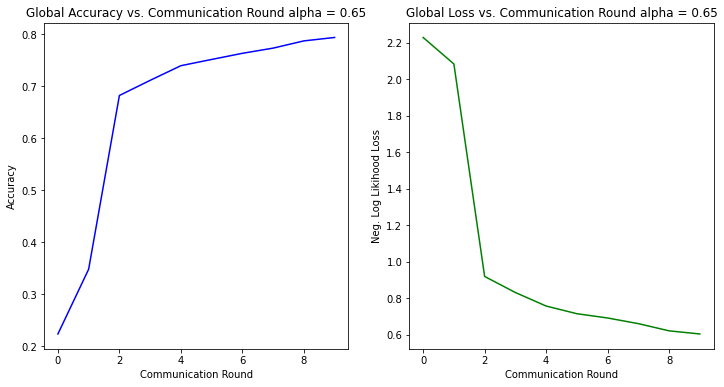

In [6]:
#vanilla_fl_dict = {'Server': [[1.791189040851593, 0.3603], [1.0364729088753462, 0.6331], [0.8723062273774296, 0.6967], [0.8009874275865033, 0.7247], [0.7405818013698329, 0.748], [0.695321643771138, 0.7635], [0.6611248622483574, 0.7776], [0.6337108630706091, 0.7858], [0.6418373847729526, 0.7834], [0.5955128319623647, 0.7997]]}
test_accuracy = [results_dict['Server'][i][1] for i in range(len(results_dict['Server']))]
test_loss = [results_dict['Server'][i][0] for i in range(len(results_dict['Server']))]

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(test_accuracy,'b')
ax[0].set_title("Global Accuracy vs. Communication Round alpha = 0.65")
ax[0].set_xlabel("Communication Round")
ax[0].set_ylabel("Accuracy")
ax[1].plot(test_loss,'g')
ax[1].set_title("Global Loss vs. Communication Round alpha = 0.65")
ax[1].set_xlabel("Communication Round")
ax[1].set_ylabel("Neg. Log Likihood Loss")
fig.show()
fig.savefig("Halt_FL_alpha=.65.png")

# Debug

In [ ]:
# to continue training: old needs to be changined for iid data: june 11th
for i in range(3,10):
  print("Starting Communication Round %d"%(i))
  print("Transfer Global Model to devices")
  for device in devices:
    device.setConvWeights(server)
    device.setDenseWeights(server)

  print("Training each device")
  for i,device in enumerate(devices):
    accuracy = device.train(trainloader,epoches)
    results_dict["Device "+str(i)].append(accuracy)
    print("Device %d has accuracy %f"%(i,accuracy))
  
  print("Aggregate device models to server")
  global_conv = []
  global_dense = []
  for device in devices:
    global_conv.append(device.getConvWeights())
    global_dense.append(device.getDenseWeights())
  x = global_conv[0]
  y = global_dense[0]
  for idx in range(1,num_devices,1):#from index 1 to the end
    x = list(map(add,x,global_conv[idx]))
    y = list(map(add,y,global_dense[idx]))
  x = [torch.div(conv,num_devices) for conv in x]
  y = [torch.div(dense,num_devices) for dense in y]
  server.set_weights(x,y)
  accuracy = server.train(trainloader,epoches)
  results_dict["Server"].append(accuracy)
print("Results Dict")
print(results_dict)

Starting Communication Round 3
Transfer Global Model to devices
Training each device


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Device 0 has accuracy 0.101000
Device 1 has accuracy 0.100000
Device 2 has accuracy 0.100000
Device 3 has accuracy 0.100000
Aggregate device models to server


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Starting Communication Round 4
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.285720
Device 1 has accuracy 0.100000
Device 2 has accuracy 0.100000
Device 3 has accuracy 0.170760
Aggregate device models to server
Starting Communication Round 5
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.340680
Device 1 has accuracy 0.232540
Device 2 has accuracy 0.100060
Device 3 has accuracy 0.321460
Aggregate device models to server
Starting Communication Round 6
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.374020
Device 1 has accuracy 0.306640
Device 2 has accuracy 0.234840


In [ ]:
print("Results Dict")
print(results_dict)

In [ ]:
# check aggregation
global_conv = []
global_dense = []
for device in devices:
  global_conv.append(device.getConvWeights())
  global_dense.append(device.getDenseWeights())
#print(global_conv)
x = global_conv[0]
y = global_dense[0]
#print(x[0][0])
for idx in range(1,num_devices,1):
  print(idx)
  x = list(map(add,x,global_conv[idx]))
  y = list(map(add,y,global_dense[idx]))
print(x[0][0])
adi = input("continue")
x = [torch.div(conv,num_devices) for conv in x]
y = [torch.div(dense,num_devices) for dense in y]
print(x[0][0])
# it works

In [ ]:
print(global_conv[0][0][0])
print(global_conv[1][0][0])
print(global_conv[2][0][0])

In [ ]:
len(global_conv)
print(range(2,num_devices,1))


In [ ]:
server.train(trainloader,epoches)

In [ ]:
a = torch.randn(4, 4)
b = torch.randn(4, 4)
torch.mean(Tensor(a,b))